<a href="https://colab.research.google.com/github/vijjus/ST-summer-2024/blob/main/ML_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Session 6 – End-to-end Machine Learning Example**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [10]:
# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()
CHAPTER_ID = "ML_example"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
      os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
tgz_path = os.path.join(HOUSING_PATH, "housing.tgz")
if not os.path.exists(tgz_path):
    fetch_housing_data()
else:
    print("Not fetching data, file exists {}".format(tgz_path))

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The __info()__ method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


When you look at the top five rows, you notice that the values in the ocean_proximity column were repetitive, which means that it is probably a __categorical attribute__.

In [7]:
# bin the values, and count each bin
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
# summary statistics for all numerical variables
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


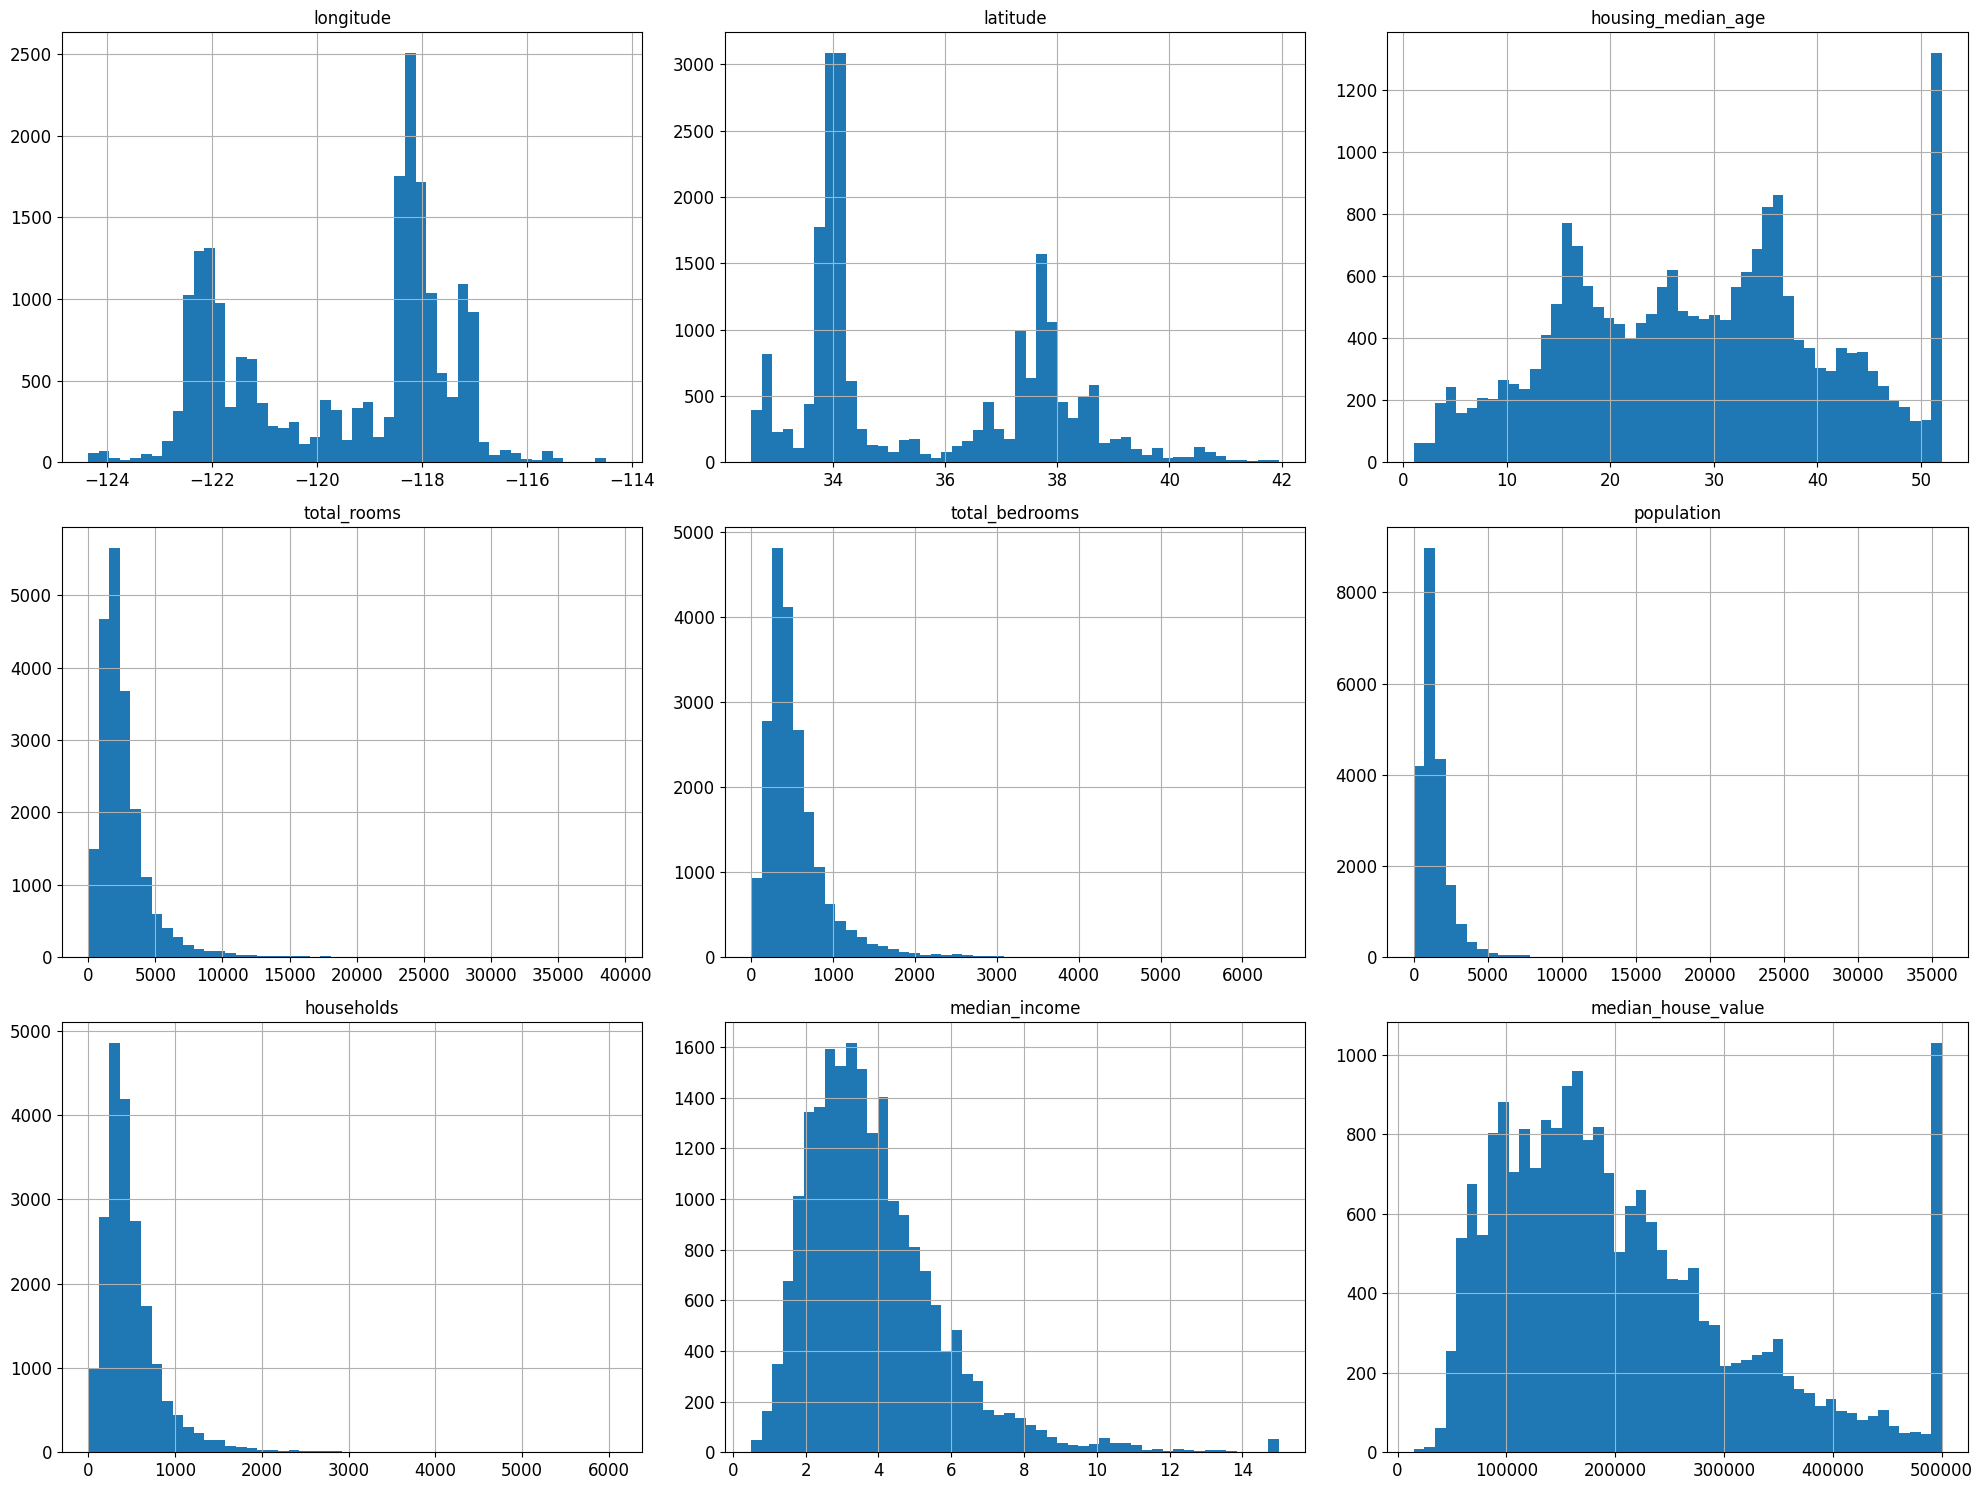

In [11]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [12]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
# Randomly permute a sequence, or return a permuted range.
eg = np.random.permutation(5)
eg

array([3, 1, 2, 0, 4])

In [15]:
# we are doing an 80/20 train/test split (sometimes 70/30)
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [17]:
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<Axes: >

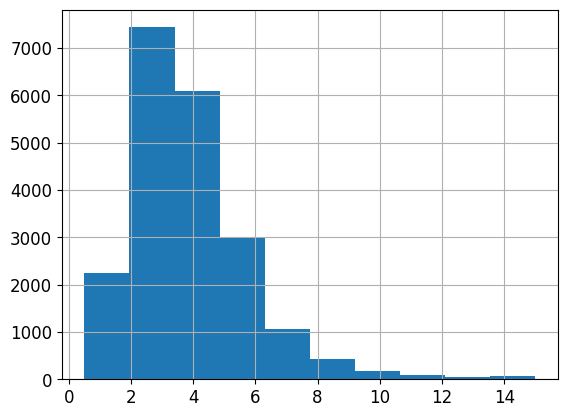

In [19]:
housing["median_income"].hist()

<Axes: >

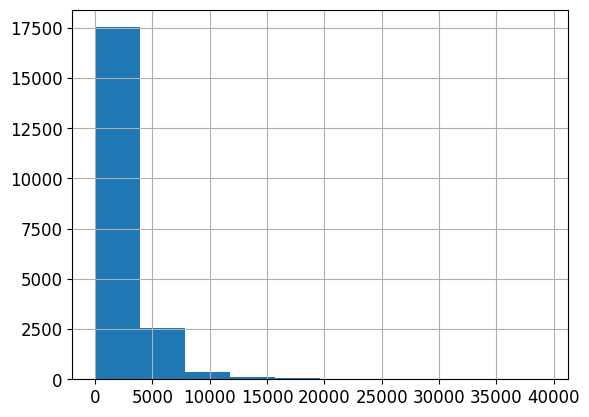

In [20]:
housing["total_rooms"].hist()

# Handling Categorical Variables

Categorical variables, also sometimes called nominal variables, are a fundamental data type in machine learning and data analysis. They represent data that can be classified into distinct categories or groups, but don't necessarily have a meaningful order or ranking between them.

Here's a breakdown of what categorical variables are and how they differ from other types:

* **Distinct Categories:** Categorical variables come in separate groups or classifications that don't inherently have a numerical order. Examples include:
    * Hair color (blonde, brunette, black, etc.)
    * Blood type (A, B, AB, O)
    * Customer satisfaction rating (poor, fair, good, excellent)
* **No Intrinsic Order:** Unlike numerical variables where higher numbers have a greater value (e.g., temperature), there's no inherent order between the categories in a categorical variable. "Blonde" hair isn't inherently better or worse than "brunette" hair, they are simply different categories.

**Types of Categorical Variables:**

There are two main subtypes of categorical variables:

1. **Nominal:** These represent unordered categories, as described above. (e.g., hair color)
2. **Ordinal:** These have a natural order, but the differences between categories may not be consistent or meaningful. For example, a movie rating system (1-5 stars) has an order, but the difference between a 3-star and a 4-star movie might be subjective and not necessarily represent twice the quality.

**Handling Categorical Variables in Machine Learning:**

* **Challenges:** Since most machine learning algorithms work best with numerical data, categorical variables need to be transformed before feeding them into models.
* **Encoding Techniques:** Common techniques for handling categorical variables include:
    * **One-Hot Encoding:** This creates new binary features for each category, essentially creating a new feature for each unique value. (e.g., hair color can be transformed into three features: "is_blonde", "is_brunette", "is_black")
    * **Ordinal Encoding:** If the categorical variable has an order (ordinal), you can assign numerical values to each category (e.g., movie rating: 1-star = 1, 2-star = 2, etc.). However, be cautious of assuming equal intervals between categories.
    * **Label Encoding:** This assigns a numerical value to each category, but unlike ordinal encoding, it doesn't necessarily imply any order. (e.g., hair color: blonde = 1, brunette = 2, etc.)

**Understanding categorical variables is crucial for effective data analysis and building robust machine learning models.** By properly handling these variables through appropriate encoding techniques, you can ensure your models can effectively learn from and make predictions based on the categorical data within your dataset.


The following code uses the pd.cut() function to create an income category attribute with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [22]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

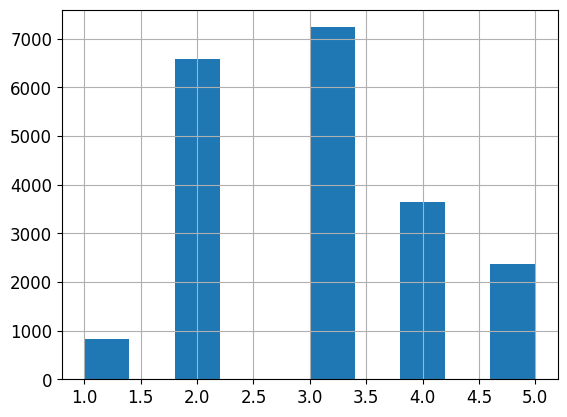

In [23]:
housing["income_cat"].hist()

In [24]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


# Statified Sampling

The `StratifiedShuffleSplit` API in scikit-learn is used for splitting data into training and testing sets while preserving the class distribution present in the original dataset. This is particularly important for classification tasks where the model's performance heavily relies on having a balanced representation of classes in both the training and testing data.

Here's a breakdown of the objective of `StratifiedShuffleSplit`:

* **Preserving Class Balance:**  Imagine you have a dataset containing images of cats and dogs. You want to train a model to classify new images. If you randomly split the data for training and testing, you might end up with an unbalanced distribution of cats and dogs in the training set. This could lead to the model performing poorly, especially for the class with fewer examples.

* **Stratified Splitting:** `StratifiedShuffleSplit` addresses this issue by performing a stratified split. It shuffles the data first and then splits it into training and testing sets while ensuring that the proportion of classes in each fold (split) is (approximately) the same as the proportion in the whole dataset.

* **Benefits of Balanced Sets:** By having a balanced class distribution in both training and testing sets, you achieve:
    * **Fair Evaluation:** The model is evaluated on a representative sample of all classes, providing a more accurate assessment of its performance on unseen data.
    * **Improved Learning:** The model is exposed to a variety of examples from each class during training, leading to better generalization capabilities.

* **Comparison with `train_test_split`:** While `train_test_split` is a commonly used function for splitting data, it doesn't guarantee balanced class distributions in the resulting splits. `StratifiedShuffleSplit` provides a more robust approach specifically for classification tasks where class balance is crucial.

**In essence, `StratifiedShuffleSplit` aims to create training and testing sets that reflect the real-world distribution of classes in your data. This helps train models that perform better and generalize more effectively.**

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [26]:
type(strat_train_set)

pandas.core.frame.DataFrame

In [27]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [28]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [29]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [30]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [31]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [32]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


# Discover and visualize the data to gain insights

In [33]:
# we abandon our old dataframe now to work on the
# new stratified training set
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


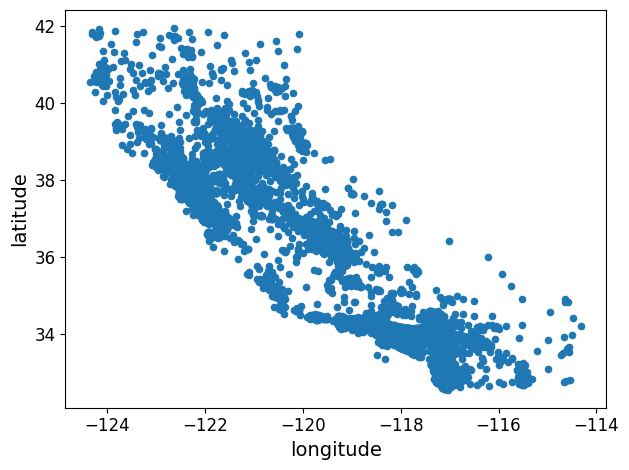

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


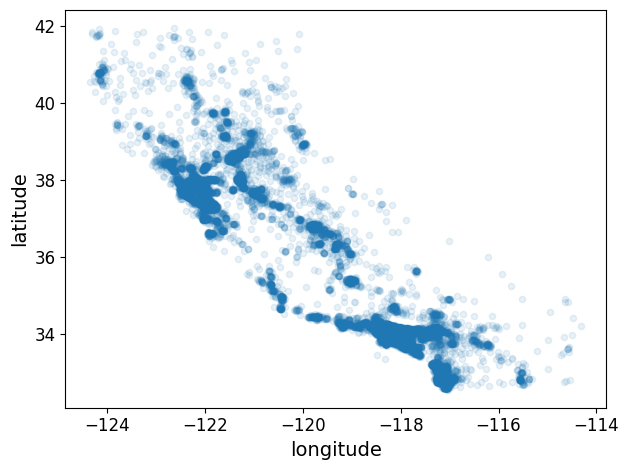

In [35]:
# alpha controls the blending level (visualizing density)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The radius of each circle represents the district’s population, and the color represents the price. We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

Saving figure housing_prices_scatterplot


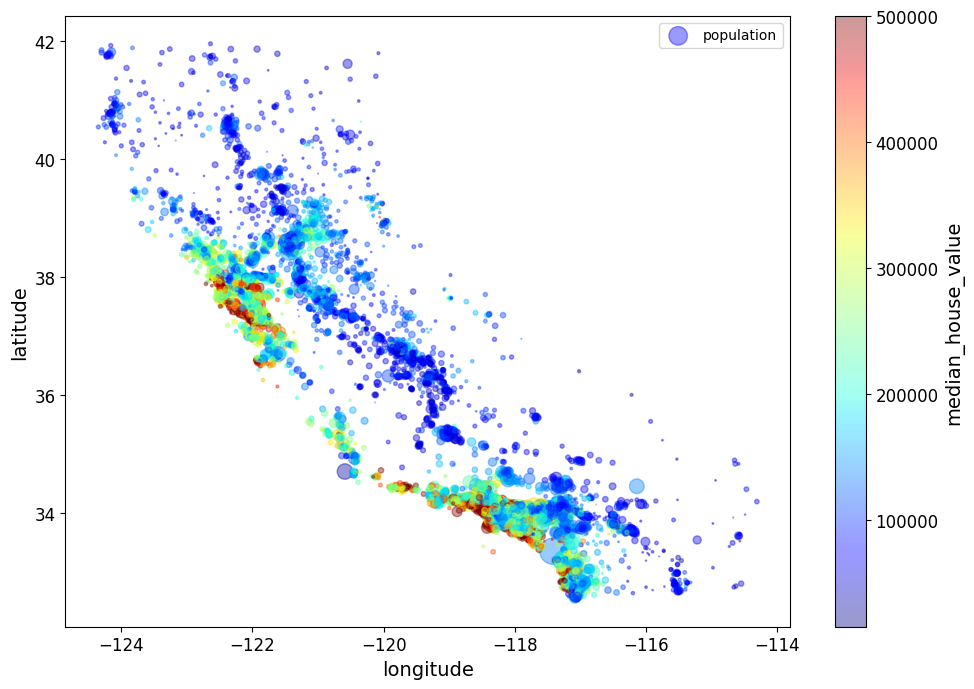

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

### Looking for Correlations ###

Saving figure scatter_matrix_plot


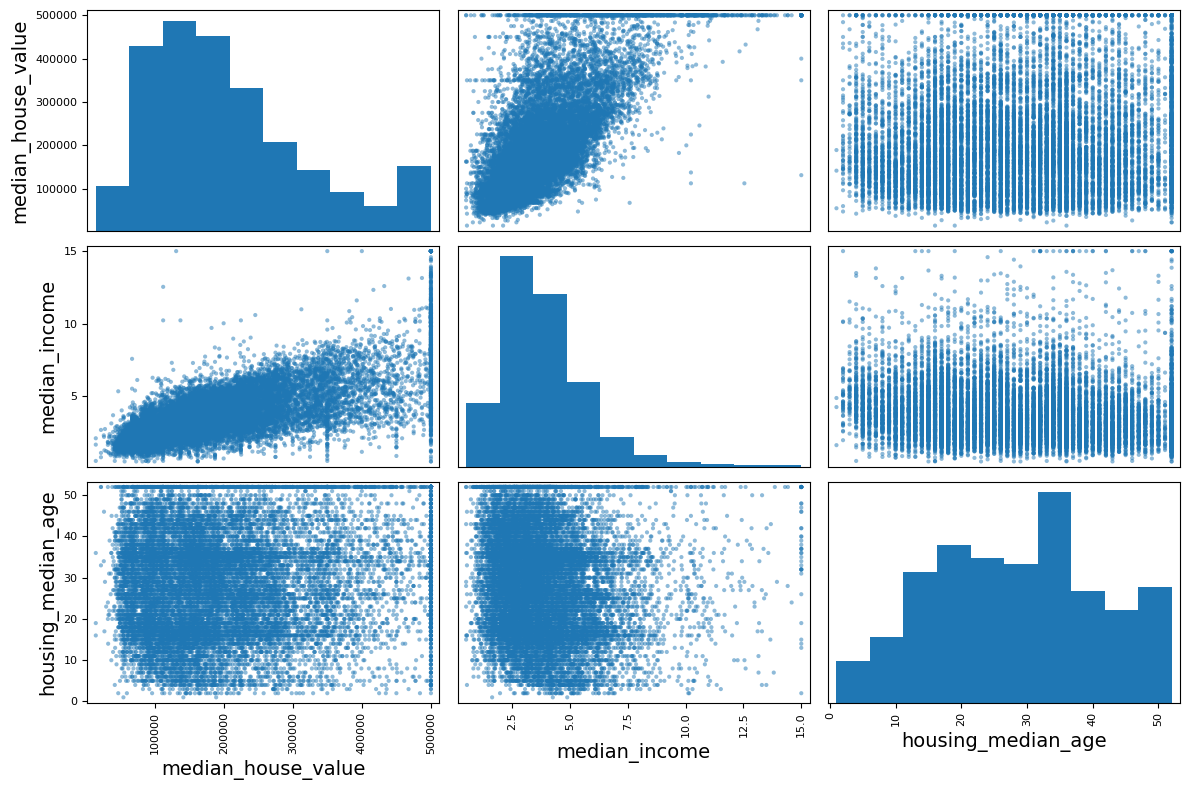

In [38]:
# from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


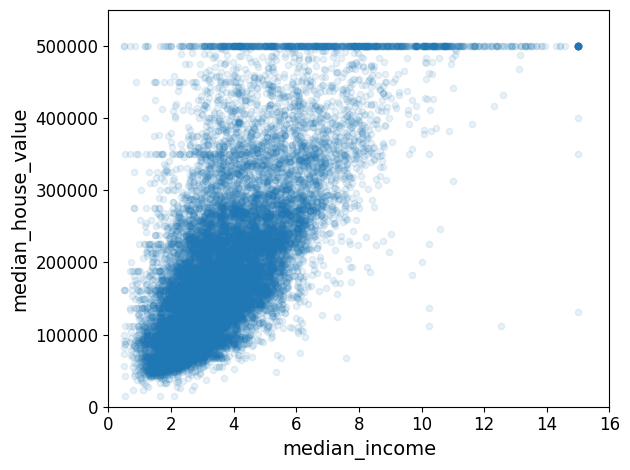

In [39]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [40]:
# remember, the data is for districts, and some values are aggregated
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

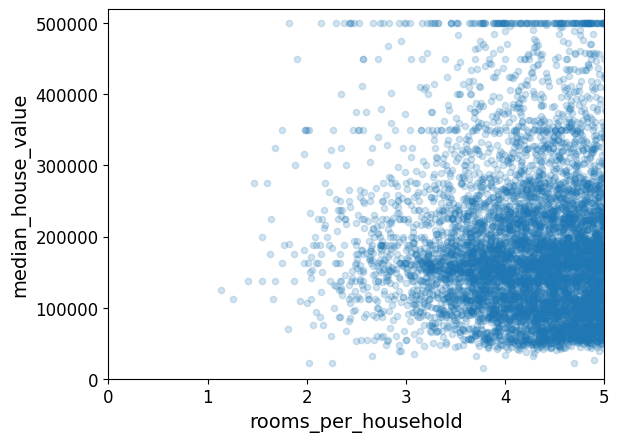

In [42]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [43]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [44]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [45]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [46]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [47]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [48]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [49]:
from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+

imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [50]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [51]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [52]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Check that this is the same as manually computing the median of each attribute:

In [53]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform the training set:

In [54]:
X = imputer.transform(housing_num)

In [55]:
type(X)

numpy.ndarray

In [56]:
X.shape

(16512, 8)

In [57]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [58]:
# the missing values have been filled with median values for those columns
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [59]:
imputer.strategy

'median'

In [60]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [61]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [62]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [63]:
type(ordinal_encoder)

sklearn.preprocessing._encoders.OrdinalEncoder

In [64]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [65]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [66]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [67]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [68]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:

In [69]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Alternatively, you can use Scikit-Learn's `FunctionTransformer` class that lets you easily create a transformer based on a transformation function (thanks to [Hanmin Qin](https://github.com/qinhanmin2014) for suggesting this code). Note that we need to set `validate=False` because the data contains non-float values (`validate` will default to `False` in Scikit-Learn 0.22).

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

Now let's build a pipeline for preprocessing the numerical attributes (note that we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from `future_encoders.py`:

In [ ]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

In [ ]:
housing_prepared.shape

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features (again, we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

The result is the same as with the `ColumnTransformer`:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

# Select and train a model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
some_data_prepared

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Fine-tune your model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

**Note**: we specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

We could compute the interval manually like this:

In [ ]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternatively, we could use a z-scores rather than t-scores:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)